# Introduction
This code tests our work on Breast Cancer Wisconsin (Diagnostic) Data Set (WDBCD) (https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data)

This code uses 10-fold technique for training the models.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

#import os
#print(os.listdir("../input"))
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

%matplotlib inline 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils



#Import models from scikit learn module:
from sklearn import datasets,metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

#Import time to measure latency
import time

# Parameters

In [2]:
epoch=30

In [3]:
#load dataset
data = pd.read_csv("/kaggle/input/wdbc-10-fold/data.csv",header = 0)
print(type(data))
data.head(5)

<class 'pandas.core.frame.DataFrame'>


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


# Data Preprocessing
## Getting input from dataset

In [4]:
Y=data.diagnosis
print(Y.value_counts())

diagnosis
B    357
M    212
Name: count, dtype: int64


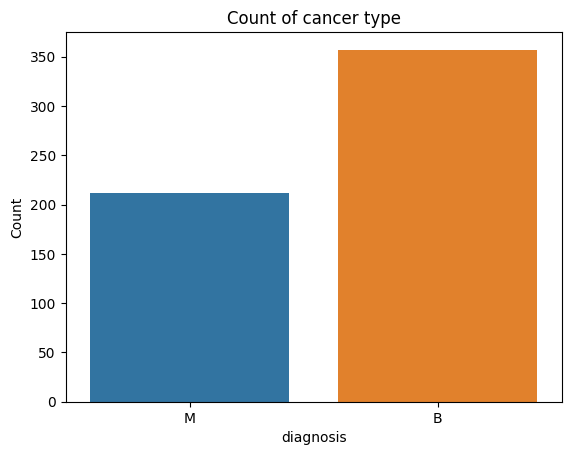

In [5]:
plt.title('Count of cancer type')
sns.countplot(x="diagnosis",data=data)
plt.ylabel('Count')
plt.show()

## Convert Class (Y) to Categorical

In [6]:
#Check befor conversion
print("Converting to categorical")
print("Before Conversion:")
print(Y.shape)
print(type(Y))


#Convert to Categorical values
Y=Y.map({'B':0,'M':1})
Y = utils.to_categorical(Y, num_classes=2)


#verify shape
print("After Conversion:")
print(Y.shape)
type(Y)

Converting to categorical
Before Conversion:
(569,)
<class 'pandas.core.series.Series'>
After Conversion:
(569, 2)


numpy.ndarray

## Prepare and clean the dataset

In [7]:
data.isnull().any().describe()

count        33
unique        2
top       False
freq         32
dtype: object

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [9]:
# drop id and unnamed 32 colums from the features
# we still need diagnosis for further statistics, 
# it will be dropped later

data.drop(['id','Unnamed: 32'],axis=1,inplace=True)

In [10]:
data.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## Analyze usable data
### Observations*
1. Mean values of cell like radius, perimeter, area, compactness, concavity,concave points etc can be used in classification of the cancer. Larger values of these parameters tends to show a correlation with malignant tumors.
2. Mean values of column like texture, smoothness, symmetry or fractual dimension does not show a particular preference of one diagnosis over the other. In any of the histograms there are no noticeable large outliers that warrants further cleanup.

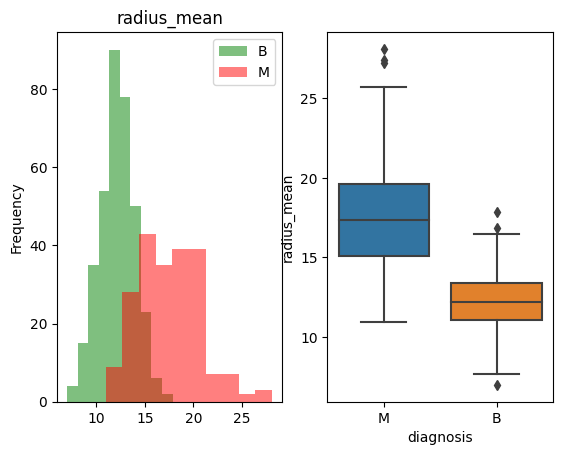

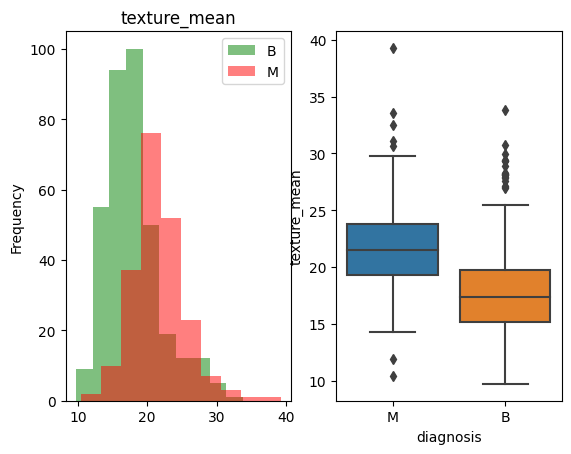

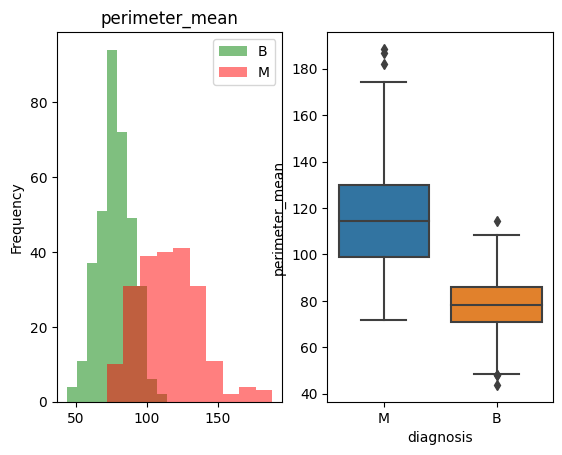

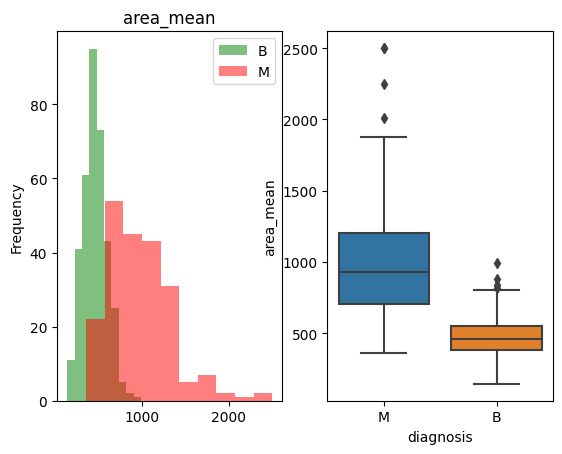

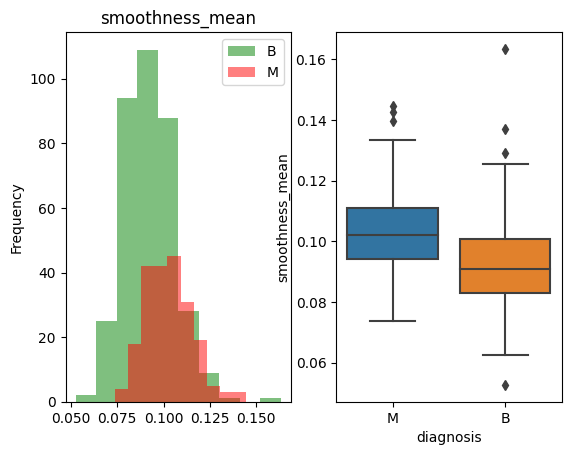

In [11]:
for i in (data.columns[1:6]):
    plt.subplot(1,2,1)
    data[i][data['diagnosis']=='B'].plot.hist(alpha=0.5,title=i,color='green')
    data[i][data['diagnosis']=='M'].plot.hist(alpha=0.5,color='red')
    plt.legend(['B','M'],loc='upper right')
    #plt.grid(visible=True)
    
    
    plt.subplot(1,2,2)
    sns.boxplot(x="diagnosis", y=i, data=data)
    plt.show()

## Remove input from data

In [12]:
#Diagnosis is in index 0, 
#so we start copying from index 1
#see, I told you we will drop it ;-)

data.drop('diagnosis',axis=1,inplace=True)
data.head(5)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Correlation matrix

In [13]:
# Create correlation matrix
data.corr()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
fractal_dimension_mean,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,...,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


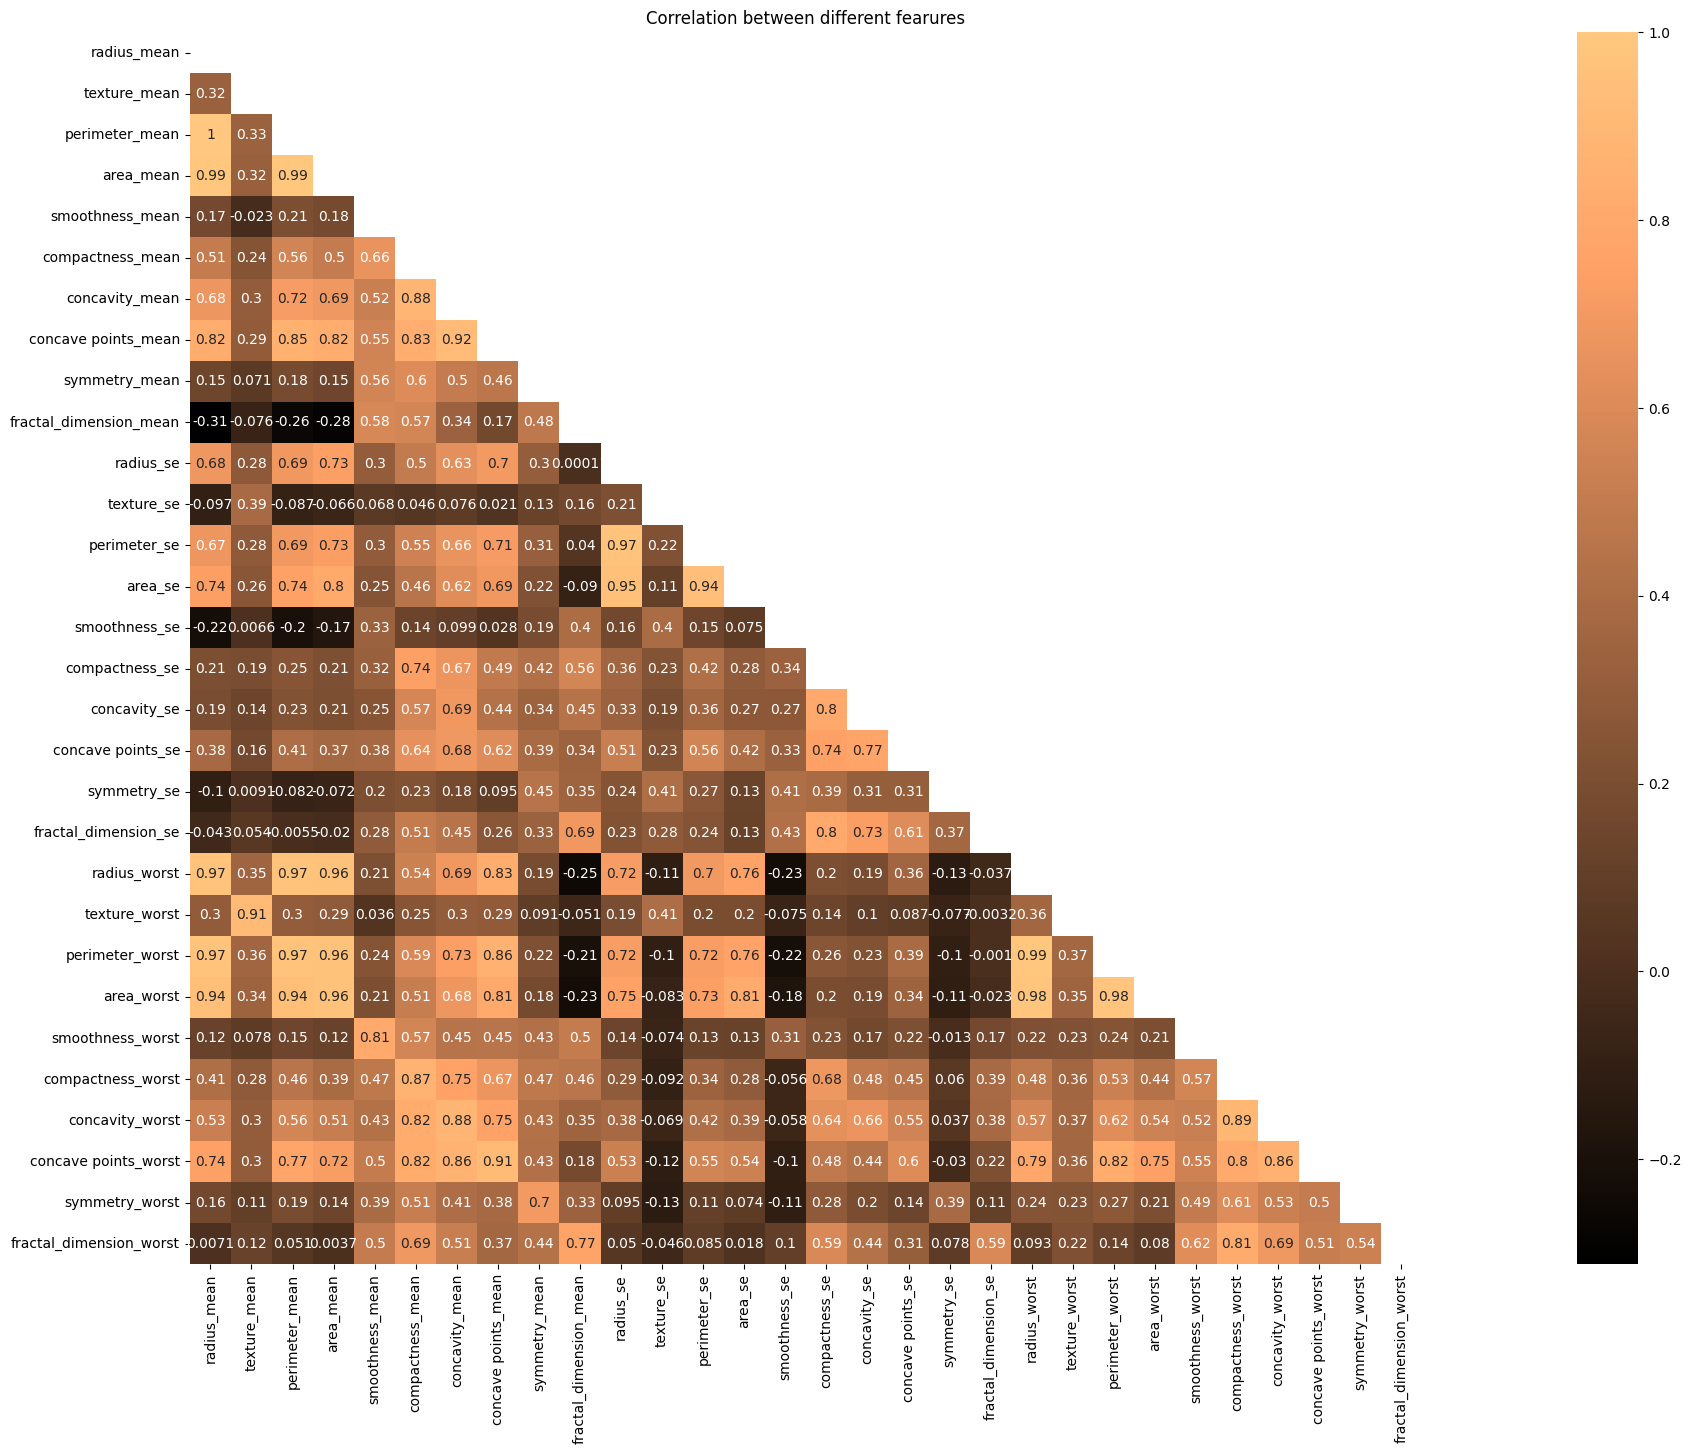

In [14]:
correlation=data.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(correlation)
plt.figure(figsize=(40,16))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='copper',mask=matrix)
plt.title('Correlation between different fearures')
plt.savefig("cor.svg")

In [15]:
type(data)

pandas.core.frame.DataFrame

## Get features (input) as X

In [16]:
#Copying data to X for bravity
X=data

#for emulating user
temp=pd.DataFrame(data=[data.values.tolist()[0]],columns=data.columns.values.tolist())
del data

#Verify :-D
print(type(X))
X.head(5)

<class 'pandas.core.frame.DataFrame'>


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Scaling
Scaling is carried out here because we are using 10-fold training

In [17]:
# Scale the data to be between -1 and 1
scaler = StandardScaler()
X=scaler.fit_transform(X)

In [18]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X)

array([[ 9.19283683e+00,  1.94858307e+00, -1.12316616e+00, ...,
        -3.39144536e-02,  4.56477199e-02, -4.71692081e-02],
       [ 2.38780180e+00, -3.76817174e+00, -5.29292687e-01, ...,
         3.26241827e-02, -5.68742432e-03, -1.86787626e-03],
       [ 5.73389628e+00, -1.07517380e+00, -5.51747593e-01, ...,
         4.70258247e-02,  3.14589659e-03,  7.50534755e-04],
       ...,
       [ 1.25617928e+00, -1.90229671e+00,  5.62730526e-01, ...,
        -2.57775589e-03,  6.70621179e-03,  3.77041667e-03],
       [ 1.03747941e+01,  1.67201011e+00, -1.87702933e+00, ...,
        -6.80863833e-02, -8.41632764e-02, -2.37828222e-02],
       [-5.47524330e+00, -6.70636791e-01,  1.49044308e+00, ...,
        -9.51587894e-03, -6.09131090e-02, -1.94755854e-02]])

In [19]:
pca.get_covariance()

array([[ 1.00176056e+00,  3.24351929e-01,  9.99612069e-01,
         9.89095475e-01,  1.70881506e-01,  5.07014640e-01,
         6.77955036e-01,  8.23976636e-01,  1.48001350e-01,
        -3.12179472e-01,  6.80285970e-01, -9.74887767e-02,
         6.75358538e-01,  7.37159198e-01, -2.22992026e-01,
         2.06362656e-01,  1.94545531e-01,  3.76831225e-01,
        -1.04504545e-01, -4.27163418e-02,  9.71245907e-01,
         2.97530545e-01,  9.66835698e-01,  9.42739295e-01,
         1.19826732e-01,  4.14190751e-01,  5.27839123e-01,
         7.45524434e-01,  1.64241985e-01,  7.07832563e-03],
       [ 3.24351929e-01,  1.00176056e+00,  3.30113223e-01,
         3.21650988e-01, -2.34296930e-02,  2.37118951e-01,
         3.02950254e-01,  2.93980713e-01,  7.15266864e-02,
        -7.65717560e-02,  2.76354360e-01,  3.87037830e-01,
         2.82169018e-01,  2.60302460e-01,  6.62542133e-03,
         1.92312595e-01,  1.43545353e-01,  1.64139495e-01,
         9.14323671e-03,  5.45533955e-02,  3.53193674e-

In [20]:
explained_variance=pca.explained_variance_ratio_
explained_variance

array([4.42720256e-01, 1.89711820e-01, 9.39316326e-02, 6.60213492e-02,
       5.49576849e-02, 4.02452204e-02, 2.25073371e-02, 1.58872380e-02,
       1.38964937e-02, 1.16897819e-02, 9.79718988e-03, 8.70537901e-03,
       8.04524987e-03, 5.23365745e-03, 3.13783217e-03, 2.66209337e-03,
       1.97996793e-03, 1.75395945e-03, 1.64925306e-03, 1.03864675e-03,
       9.99096464e-04, 9.14646751e-04, 8.11361259e-04, 6.01833567e-04,
       5.16042379e-04, 2.72587995e-04, 2.30015463e-04, 5.29779290e-05,
       2.49601032e-05, 4.43482743e-06])

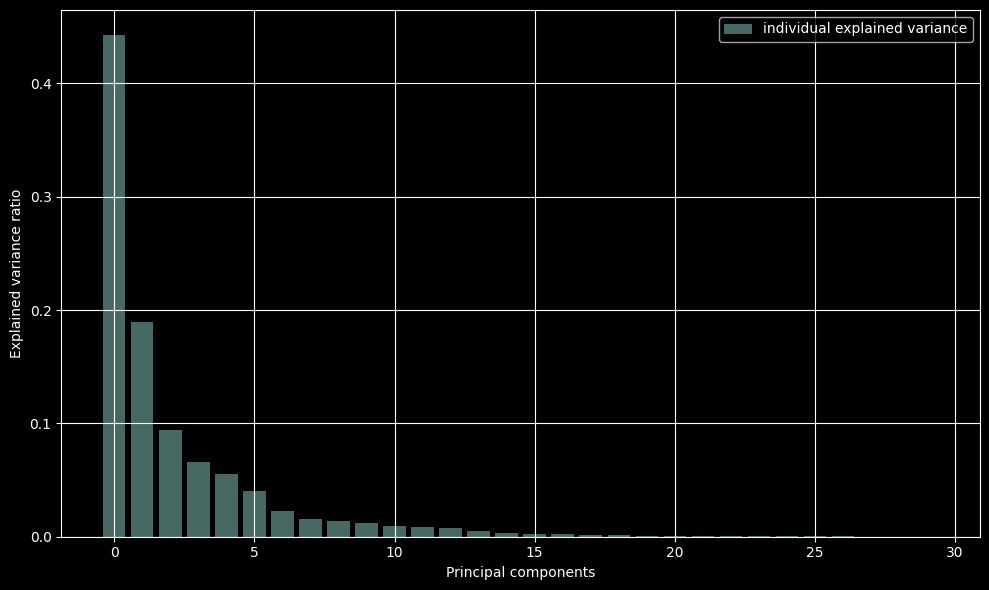

In [21]:
# We used logarithmic scale in the y-axis becaus the first value is so high

with plt.style.context('dark_background'):
    fig=plt.figure(figsize=(10, 6))
    ax = fig.add_subplot()

    ax.bar(range(30), explained_variance, alpha=0.5, align='center',
            label='individual explained variance')
    
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.grid(visible=True)
    plt.tight_layout()

Thus we can see from the above plot that first three components constitute almost 73% of the variance. Fourth to twenty sixth components has 25% of the data sprad.The remaining component has less than 0.001% of the variance.Hence we can drop from 27 to 30th component(total of 4 features)



In [22]:
pca=PCA(n_components=26)
X_new=pca.fit_transform(X)
X_new

array([[ 9.19283683e+00,  1.94858307e+00, -1.12316616e+00, ...,
        -1.75256284e-01, -1.51020059e-01, -2.01503451e-01],
       [ 2.38780180e+00, -3.76817174e+00, -5.29292687e-01, ...,
         1.12901180e-02, -1.70510254e-01, -4.11287846e-02],
       [ 5.73389628e+00, -1.07517380e+00, -5.51747593e-01, ...,
         1.02761759e-01,  1.71158125e-01,  4.73541163e-03],
       ...,
       [ 1.25617928e+00, -1.90229671e+00,  5.62730526e-01, ...,
        -4.48191456e-02,  2.42875704e-03,  7.09526541e-03],
       [ 1.03747941e+01,  1.67201011e+00, -1.87702933e+00, ...,
        -1.95968973e-01,  3.77830448e-01, -1.98192090e-01],
       [-5.47524330e+00, -6.70636791e-01,  1.49044308e+00, ...,
        -7.51108972e-02, -1.75080109e-02,  3.47115038e-01]])

In [23]:
pca.get_covariance()

array([[ 1.00287890e+00,  3.24338364e-01,  9.98613048e-01,
         9.89138224e-01,  1.70914893e-01,  5.07128083e-01,
         6.78217070e-01,  8.23699079e-01,  1.47987925e-01,
        -3.12246205e-01,  6.80409669e-01, -9.75003629e-02,
         6.75444823e-01,  7.36937024e-01, -2.22997802e-01,
         2.06392192e-01,  1.94487431e-01,  3.76808453e-01,
        -1.04519010e-01, -4.27204395e-02,  9.70778810e-01,
         2.97550747e-01,  9.66706526e-01,  9.43131854e-01,
         1.19811575e-01,  4.14136208e-01,  5.27746841e-01,
         7.45675014e-01,  1.64261597e-01,  7.11741180e-03],
       [ 3.24338364e-01,  1.00175937e+00,  3.30097198e-01,
         3.21695071e-01, -2.34241155e-02,  2.37127415e-01,
         3.02979345e-01,  2.93944751e-01,  7.15256112e-02,
        -7.65799046e-02,  2.76369250e-01,  3.87037177e-01,
         2.82172420e-01,  2.60279076e-01,  6.62467264e-03,
         1.92316231e-01,  1.43538402e-01,  1.64139013e-01,
         9.14174214e-03,  5.45525821e-02,  3.53190107e-

In [24]:
explained_variance=pca.explained_variance_ratio_
explained_variance

array([4.42720256e-01, 1.89711820e-01, 9.39316326e-02, 6.60213492e-02,
       5.49576849e-02, 4.02452204e-02, 2.25073371e-02, 1.58872380e-02,
       1.38964937e-02, 1.16897819e-02, 9.79718988e-03, 8.70537901e-03,
       8.04524987e-03, 5.23365745e-03, 3.13783217e-03, 2.66209337e-03,
       1.97996793e-03, 1.75395945e-03, 1.64925306e-03, 1.03864675e-03,
       9.99096464e-04, 9.14646751e-04, 8.11361259e-04, 6.01833567e-04,
       5.16042379e-04, 2.72587995e-04])

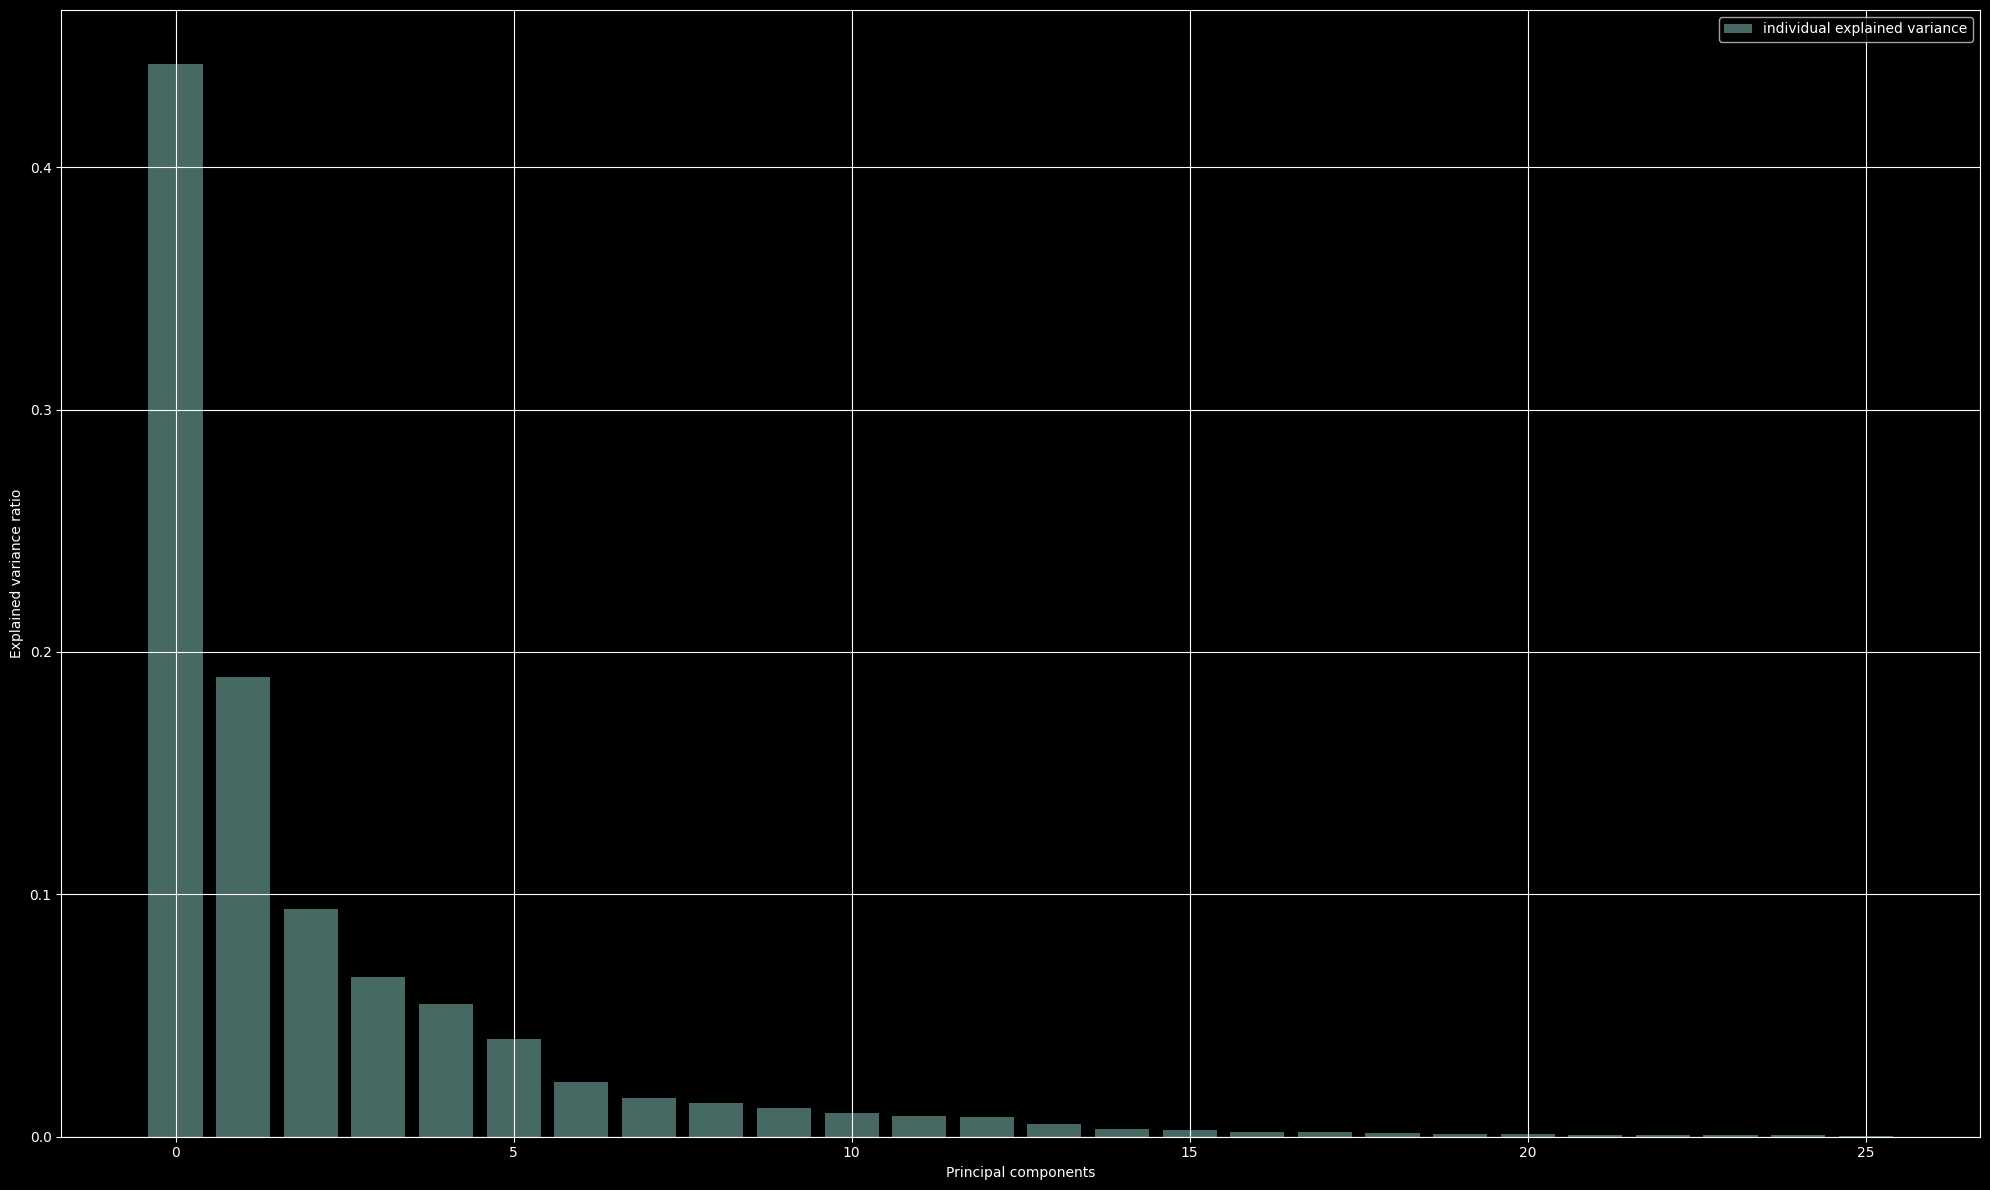

In [25]:
# We used logarithmic scale in the y-axis becaus the first value is so high

with plt.style.context('dark_background'):
    fig=plt.figure(figsize=(20, 12))
    ax = fig.add_subplot()

    ax.bar(range(26), explained_variance, alpha=0.5, align='center',
            label='individual explained variance')

    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.grid(visible=True)
    plt.tight_layout()

## Final value of X

In [26]:
X=X_new
X.shape

(569, 26)

## Reshaping X

In [27]:
X=X.reshape(X.shape[0],X.shape[1],1)
print(X.shape)

(569, 26, 1)


## Checking Y

In [28]:
print(Y.shape)
Y

(569, 2)


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

# Construct Distiller class

In [29]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

# Creating TM, SM, and SM_scratch

In [30]:
# Define the K-fold Cross Validator
# Define per-fold score containers <-- these are new
T_acc_per_fold = []
T_loss_per_fold = []

S_acc_per_fold = []
S_loss_per_fold = []

TS_acc_per_fold = []
TS_loss_per_fold = []
num_folds=4

kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, Y):
    # Create the teacher
    teacher = keras.Sequential(
    [
        keras.Input(shape=(X.shape[1], 1)),
        layers.Conv1D(filters=64,kernel_size= 2,activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        
        layers.Conv1D(448, 2,activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        layers.Dense(64,activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(2,activation='sigmoid'),
    ],
    name="teacher",
    )
    
    # Create the student
    student = keras.Sequential(
    [
        keras.Input(shape=(X.shape[1], 1)),
        layers.Conv1D(4, 2),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
       # layers.LeakyReLU(alpha=0.2),
        
        layers.Conv1D(8, 2),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        layers.Dense(2,activation='sigmoid'),
    ],
    name="student",)
    
    # Clone student for later comparison
    student_scratch = keras.models.clone_model(student)
    
    #compile teacher
    teacher.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',
              metrics=['accuracy'])
    
    # Generate a print
    print( sep='\n')
    print( sep='\n')
    print('---------------------+++++++++++++++++++++++++++++----------------------')
    print( sep='\n')
    print(f'Training for fold {fold_no} ...')
    print( sep='\n')
    print('TEACHER')
    # Fit data to model
    teacherHistory = teacher.fit(X[train], Y[train],epochs=epoch,validation_data=(X[test],Y[test]),
              #batch_size=batch_size,
            
              verbose=1)
    # Generate generalization 
    scores = teacher.evaluate(X[test], Y[test])
    print(f'Score for fold {fold_no}: {teacher.metrics_names[0]} of {scores[0]}; {teacher.metrics_names[1]} of {scores[1]*100}%')
    T_acc_per_fold.append(scores[1] * 100)
    T_loss_per_fold.append(scores[0])


    
    #compile STUDENT
    student_scratch.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',
              metrics=['accuracy'])
    print( sep='\n')
    print('STUDENT')
    
    studentHistory=student_scratch.fit(X[train],Y[train],epochs=epoch,validation_data=(X[test],Y[test]),verbose=1)
    
    # Generate generalization
    Scores= student_scratch.evaluate(X[test],Y[test])
    print(f'Score for fold {fold_no}: {student_scratch.metrics_names[0]} of {Scores[0]}; {student_scratch.metrics_names[1]} of {Scores[1]*100}%')
    S_acc_per_fold.append(Scores[1] * 100)
    S_loss_per_fold.append(Scores[0])
    
    
    
    # Initialize and compile distiller
    distiller = Distiller(student=student, teacher=teacher)
    distiller.compile(optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn= keras.losses.BinaryCrossentropy() ,
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
    )
    
    
    # Distill teacher to student
    print( sep='\n')
    print('DISTILL TEACHER TO STUDENT')
    history=distiller.fit(X[train], Y[train], epochs=epoch, verbose=1, validation_data=(X[test],Y[test]))
    # print("sdfghjkl ",history.history)
    # Generate generalization
    Scores= distiller.evaluate(X[test],Y[test])
    #print(Scores)
    print(f'Score for fold {fold_no}: loss of {Scores[1]}; {distiller.metrics_names[0]} of {Scores[0]*100}%')
    #print(distiller.metrics_names)
    TS_acc_per_fold.append(Scores[0] * 100)
    TS_loss_per_fold.append(Scores[1])
    
    
    # Increase fold number
    fold_no = fold_no + 1
    
    
print( sep='\n')
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Teachers Score per fold')
for i in range(0, len(T_acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {T_loss_per_fold[i]} - Accuracy: {T_acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Teachers Average scores for all folds:')
print(f'> Accuracy: {np.mean(T_acc_per_fold)} (+- {np.std(T_acc_per_fold)})')
print(f'> Loss: {np.mean(T_loss_per_fold)}')
print('------------------------------------------------------------------------')
     
print( sep='\n')
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Students Score per fold')
for i in range(0, len(S_acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {S_loss_per_fold[i]} - Accuracy: {S_acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Students Average scores for all folds:')
print(f'> Accuracy: {np.mean(S_acc_per_fold)} (+- {np.std(S_acc_per_fold)})')
print(f'> Loss: {np.mean(S_loss_per_fold)}')
print('------------------------------------------------------------------------')


print( sep='\n')
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('knowledge distill Score per fold')
for i in range(0, len(TS_acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {TS_loss_per_fold[i]} - Accuracy: {TS_acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('knowledge distill Average scores for all folds:')
print(f'> Accuracy: {np.mean(TS_acc_per_fold)} (+- {np.std(TS_acc_per_fold)})')
print(f'> Loss: {np.mean(TS_loss_per_fold)}')
print('------------------------------------------------------------------------')
     
     



---------------------+++++++++++++++++++++++++++++----------------------

Training for fold 1 ...

TEACHER
Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7072 - loss: 0.6642 - val_accuracy: 0.9301 - val_loss: 0.6615
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9544 - loss: 0.1965 - val_accuracy: 0.9441 - val_loss: 0.6286
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9750 - loss: 0.1069 - val_accuracy: 0.9441 - val_loss: 0.5980
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9796 - loss: 0.0676 - val_accuracy: 0.9441 - val_loss: 0.5704
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9750 - loss: 0.0759 - val_accuracy: 0.9510 - val_loss: 0.5332
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9842 - loss: 0.0496 - val_accuracy: 0.9580 - val_loss: 0.5007
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9846 - loss: 0.0427 - val_accuracy: 0.9650 - val_loss: 0.4818
Ep

/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:578: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5057 - distillation_loss: 0.0013 - loss: 0.4969 - student_loss: 0.8937 - val_accuracy: 0.6573 - val_loss: 0.4972 - val_student_loss: 0.7770
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5678 - distillation_loss: 0.0011 - loss: 0.5031 - student_loss: 0.7102 - val_accuracy: 0.7133 - val_loss: 0.4930 - val_student_loss: 0.7296
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7154 - distillation_loss: 9.5975e-04 - loss: 0.5022 - student_loss: 0.6462 - val_accuracy: 0.7552 - val_loss: 0.4886 - val_student_loss: 0.6747
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7603 - distillation_loss: 8.5057e-04 - loss: 0.4878 - student_loss: 0.5740 - val_accuracy: 0.7902 - val_loss: 0.4862 - val_student_loss: 0.6174
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8023 - distillation_loss: 7.4099e-04 - loss: 0.4887 - student_loss: 0.5206 - val_accuracy: 0.8671 - val_loss: 0.4840 - val

# Student and Teacher Structure

In [31]:
teacher.summary()

Model: "teacher"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 25, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 25, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 24, 448)        │        57,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 448)        │         1,792 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 24, 448)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 10752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │       688,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,243,016 (8.56 MB)

 Trainable params: 747,330 (2.85 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 1,494,662 (5.70 MB)

In [32]:
student.summary()

Model: "student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 25, 4)          │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 25, 4)          │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 25, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 24, 8)          │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 24, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 518 (2.02 KB)

 Trainable params: 494 (1.93 KB)

 Non-trainable params: 24 (96.00 B)

 # Function ploting accuracies and losses
 ## Function plotting single model

In [33]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='lower right')
  plt.grid(visible=True)
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper right')
  plt.grid(visible=True)
  plt.show()

## Function pltting KD

In [34]:
def plotKDCurveD(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='lower right')
  plt.grid(visible=True)
  plt.show()

  plt.plot(epochRange,history.history['student_loss'])
  plt.plot(epochRange,history.history['val_student_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.grid(visible=True)
  plt.show()

## Function plotting KD and other models

In [35]:
def plotKDCurveProf(his,tHis,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,tHis.history['accuracy'])
  plt.plot(epochRange,tHis.history['val_accuracy'])
  plt.plot(epochRange,his.history['accuracy'])
  plt.plot(epochRange,his.history['val_accuracy'])

  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['T_train','T_val','KD_train','KD_val'],loc='lower right')
  plt.grid(visible=True)
  plt.show()


  plt.plot(epochRange,tHis.history['loss'])
  plt.plot(epochRange,tHis.history['val_loss'])
  plt.plot(epochRange,his.history['student_loss'])
  plt.plot(epochRange,his.history['val_student_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['T_train','T_val','KD_train','KD_val'],loc='upper left')
  plt.grid(visible=True)
  plt.show()

# Plotting accuracies and losses
## Plotting teacher model

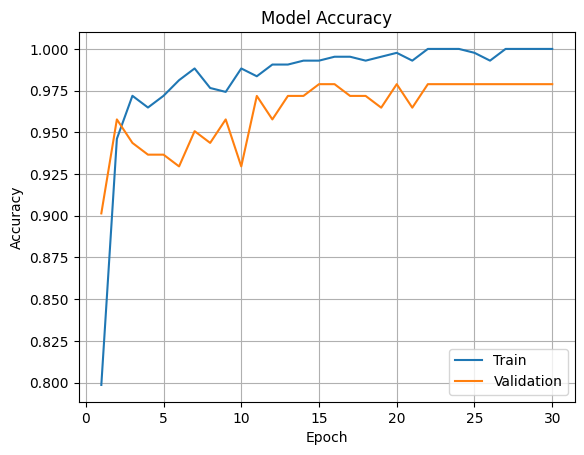

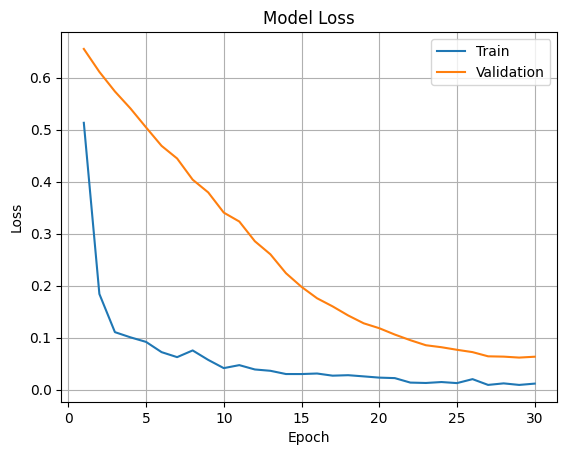

In [36]:
plotLearningCurve(teacherHistory,epoch)

## Plotting student model (without KD)

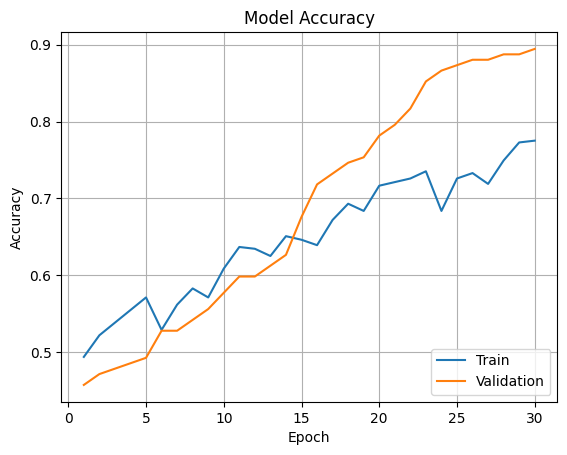

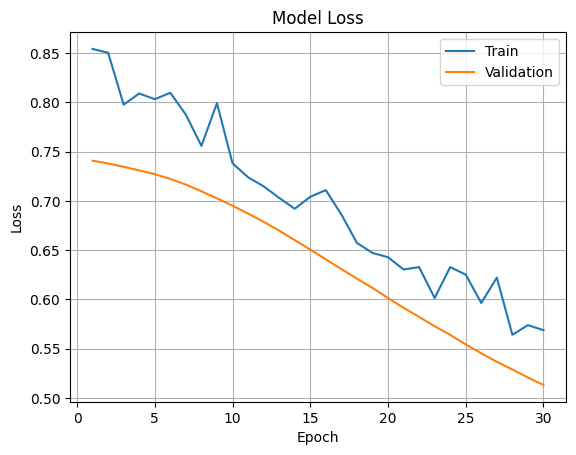

In [37]:
plotLearningCurve(studentHistory,epoch)

## Plotting Student model (with KD)

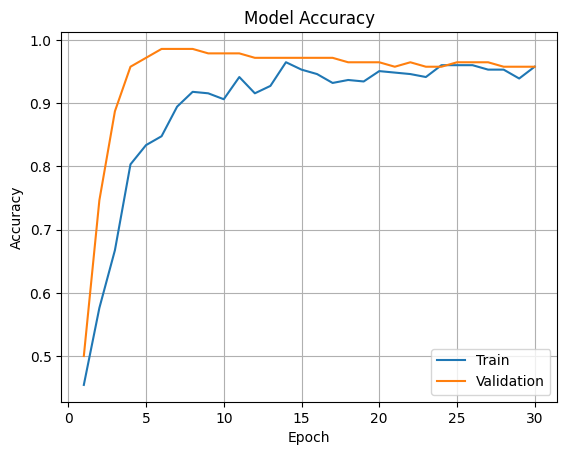

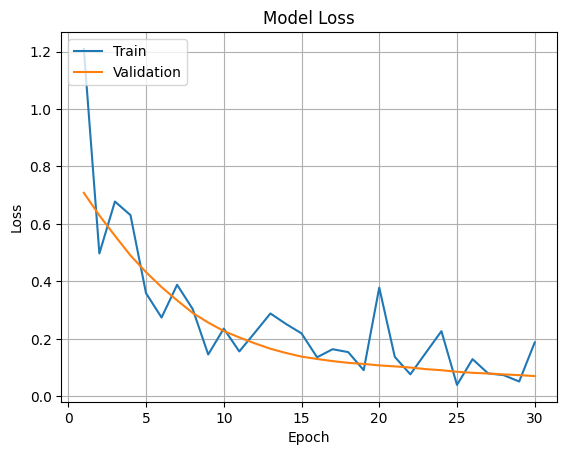

In [38]:
plotKDCurveD(history,epoch)

# Comparing Models

## Plotting Student Model (with KD) and Teacher Model

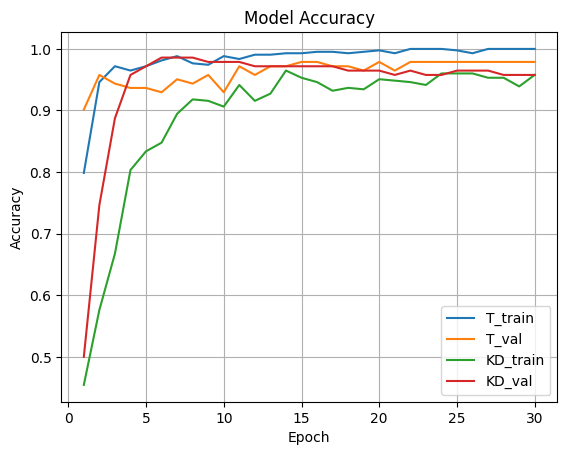

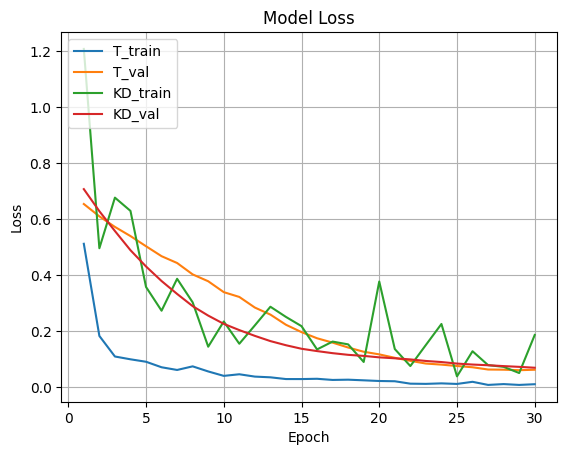

In [39]:
plotKDCurveProf(history,teacherHistory,epoch)

## Student with KD Vs Student without Kd

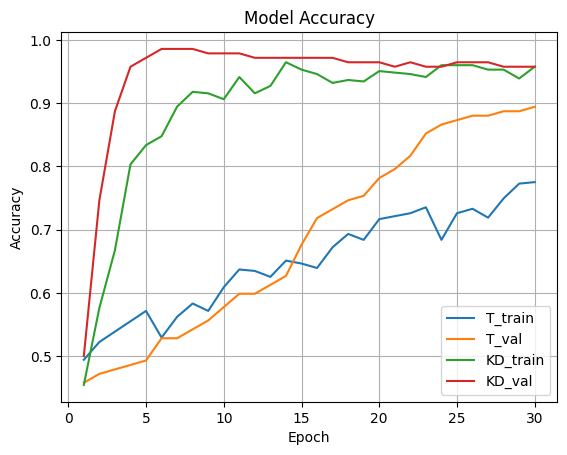

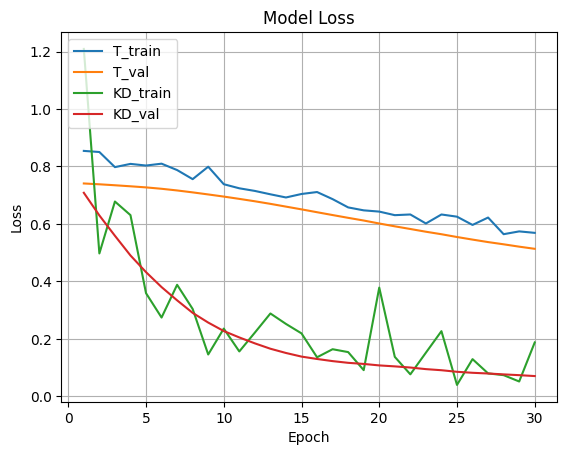

In [40]:
plotKDCurveProf(history,studentHistory,epoch)

# Saving Model

In [41]:
#distiller.save("trained_student.hd5")
#print("file size is : ",round(os.path.getsize('trained_student.hd5')/1024**2, 2), 'MB')

#Code shows the error below
#ValueError: Model <__main__.Distiller object at 0x7f7878506610> cannot be saved because the 
#input shapes have not been set. Usually, input shapes are automatically determined from calling `.fit()` 
#or `.predict()`. To manually set the shapes, call `model.build(input_shape)`.

In [42]:
distiller.evaluate(X[test], Y[test])
print(f'Score for fold {fold_no}: {teacher.metrics_names[0]} of {scores[0]}; {teacher.metrics_names[1]} of {scores[1]*100}%')

print(distiller)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9486 - loss: 0.5011 - student_loss: 0.0973 
Score for fold 5: loss of 0.06315832585096359; compile_metrics of 97.88732528686523%
<Distiller name=distiller_3, built=False>


# Emulating a User

In [43]:
#Use existing Scale in line 174 on the data to be between -1 and 1
testing_data=scaler.transform(temp)

#Use exisiting PCA in line 179 to transform the data 
testing_data=pca.transform(testing_data)
X_data=testing_data.reshape(1,26,1)

In [44]:
distiller.student.predict(X_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


array([[9.5791700e-05, 9.9969745e-01]], dtype=float32)